In [1]:
import pandas as pd
import sys
sys.path.append('/home/jiguo/denovo_rpe1_scrnaseq/analysis_pipeline')
import functions as f
import matplotlib.pyplot as plt

In [2]:
def check_location_of_genes(gene_list, gene_index=None, database_file="/home/jiguo/data/data/location/subcellular_location_data.tsv", keep_uncertain=True):
    """
    Check the location of genes in the database.
    will return a metrix where rows are genes and columns are unique locations.
    values in the matrix are:
    1: Approved, 2: Supported, 3: Enhanced, 0: Uncertain, NaN: Not found in the database.
    """
    # load the databases which contain the location information from hpa, need to be .tsv file
    if database_file.endswith('.tsv'):
        location_data = pd.read_csv(database_file, sep='\t', low_memory=False, header=0)
    else:
        print("Error: The database file must be a .tsv file.")
        return None
    location_data = location_data[["Reliability", "Approved", "Supported", "Gene name","Enhanced",'Uncertain']]
    if keep_uncertain==False:
        location_data = location_data[location_data['Reliability'] != 'Uncertain']
    # if gene_list is a file, read it using load_gene_list
    if isinstance(gene_list, str):
        gene_list = f.load_gene_list(gene_list, gene_index=gene_index)
    # if gene_list is a list, convert it to a pandas Series
    if gene_list is not None:
        location_data = location_data[location_data['Gene name'].isin(gene_list)]
    else: # use all the genes in the database
        print("No gene list provided, using all genes in the database.")
        location_data = location_data
    if location_data.empty:
        print("No genes found in the database.")
        return None 
    # columns indeices are all the unique locations from both "Approved", "Supported", "Enhanced", "Uncertain"
    unique_locations = set()
    for index, row in location_data.iterrows():
        # drop nan values in the columns "Approved", "Supported", "Enhanced", "Uncertain"
        if pd.isna(row["Approved"]) or pd.isna(row["Supported"]) or pd.isna(row["Enhanced"]) or pd.isna(row["Uncertain"]):
            # change nan to empty string
            row["Approved"] = "" if pd.isna(row["Approved"]) else row["Approved"]
            row["Supported"] = "" if pd.isna(row["Supported"]) else row["Supported"]
            row["Enhanced"] = "" if pd.isna(row["Enhanced"]) else row["Enhanced"]
            row["Uncertain"] = "" if pd.isna(row["Uncertain"]) else row["Uncertain"]
        # split the locations by ";"
        approved_locations = row["Approved"].split(";")
        supported_locations = row["Supported"].split(";")
        enhanced_locations = row["Enhanced"].split(";")
        uncertain_locations = row["Uncertain"].split(";")
        unique_locations.update(approved_locations)
        unique_locations.update(supported_locations)
        unique_locations.update(enhanced_locations)
        unique_locations.update(uncertain_locations)
    unique_locations = sorted(unique_locations)
    unique_locations.remove("")  # remove empty string if exists
    # Create a Matrix to store the results
    results = pd.DataFrame(columns=["Gene name", "Location"])
    for location in unique_locations:
        results[location] = 0  # initialize all locations to 0
    results['Gene name'] = location_data['Gene name']  # add the gene names to the first column
    for index, row in location_data.iterrows():
        if pd.isna(row["Approved"]) or pd.isna(row["Supported"]) or pd.isna(row["Enhanced"]) or pd.isna(row["Uncertain"]):
            # change nan to empty string
            row["Approved"] = "" if pd.isna(row["Approved"]) else row["Approved"]
            row["Supported"] = "" if pd.isna(row["Supported"]) else row["Supported"]
            row["Enhanced"] = "" if pd.isna(row["Enhanced"]) else row["Enhanced"]
            row["Uncertain"] = "" if pd.isna(row["Uncertain"]) else row["Uncertain"]
        gene_name = row["Gene name"]
        approved_locations = row["Approved"].split(";")
        supported_locations = row["Supported"].split(";")
        enhanced_locations = row["Enhanced"].split(";")
        uncertain_locations = row["Uncertain"].split(";")
        # if the gene location is in the unique locations, set the value to 1
        for location in approved_locations:
            if location in unique_locations:
                results.loc[results['Gene name'] == gene_name, location] = 1
        for location in supported_locations:
            if location in unique_locations:
                results.loc[results['Gene name'] == gene_name, location] = 2
        for location in enhanced_locations:
            if location in unique_locations:
                results.loc[results['Gene name'] == gene_name, location] = 3
            for location in uncertain_locations:
                if location in unique_locations:
                    results.loc[results['Gene name'] == gene_name, location] = 0  
    return results

In [3]:
results = check_location_of_genes(gene_list='/home/jiguo/denovo_rpe1_scrnaseq/Genes_with_GO_terms_RNA-metabolic-process - select.csv',gene_index="Gene names", database_file="/home/jiguo/data/data/location/subcellular_location_data.tsv")

In [4]:
results

,Gene name,Location,Acrosome,Actin filaments,Aggresome,Annulus,Basal body,Calyx,Cell Junctions,Centriolar satellite,...,Nucleoli rim,Nucleoplasm,Perinuclear theca,Plasma membrane,Primary cilium,Primary cilium tip,Primary cilium transition zone,Principal piece,Rods & Rings,Vesicles
6,NFYA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,LAS1L,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,RBM5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2.0,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN
39,RBM6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54,UPF1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13334,TAF9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13400,TYW1B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13415,DDX52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13431,MRM1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [75]:
results = check_location_of_genes(gene_list=None, gene_index=None, database_file="/home/jiguo/data/data/location/subcellular_location_data.tsv", keep_uncertain=True)

No gene list provided, using all genes in the database.


In [6]:
def plot_location_of_genes(result_matrix, showReliability=True, xstikrotation=90):
    """
    Plot the location of genes in the database.
    """
    if showReliability:
        # Create separate counts for each reliability level (1=Approved, 2=Supported, 3=Enhanced)
        approved_counts = result_matrix.iloc[:, 1:].apply(lambda x: (x == 1).sum(), axis=0)
        supported_counts = result_matrix.iloc[:, 1:].apply(lambda x: (x == 2).sum(), axis=0)
        enhanced_counts = result_matrix.iloc[:, 1:].apply(lambda x: (x == 3).sum(), axis=0)
        uncertain_counts = result_matrix.iloc[:, 1:].apply(lambda x: (x == 0).sum(), axis=0)
        # Filter to only include localizations that have at least one gene
        locations_with_genes = result_matrix.iloc[:, 1:].apply(lambda x: (x >= 0).sum(), axis=0)
        locations_with_genes = locations_with_genes[locations_with_genes > 0]
        # print how many locations have been excluded and what is it
        print(f"Number of locations with genes: {len(locations_with_genes)}")
        print(f"Number of locations excluded: {len(result_matrix.columns) - len(locations_with_genes)}")
        print(f"Excluded locations: {set(result_matrix.columns) - set(locations_with_genes.index)}")
        # print how many locations have been included
        # Filter counts to only include these locations
        approved_counts = approved_counts[locations_with_genes.index]
        supported_counts = supported_counts[locations_with_genes.index]
        enhanced_counts = enhanced_counts[locations_with_genes.index]
        uncertain_counts = uncertain_counts[locations_with_genes.index]
        # Create stacked bar chart
        plt.figure(figsize=(30, 20))
        width = 0.8
        x_pos = range(0, len(locations_with_genes))
        plt.bar(x_pos, approved_counts, width, label='Approved', color='#8AAAE5', alpha=0.8)
        plt.bar(x_pos, supported_counts, width, bottom=approved_counts, label='Supported', color='#375E97', alpha=0.8)
        plt.bar(x_pos, enhanced_counts, width, bottom=approved_counts + supported_counts, label='Enhanced', color='#FB6542', alpha=0.8)
        plt.bar(x_pos, uncertain_counts, width, bottom=approved_counts + supported_counts + enhanced_counts, label='Uncertain', color='#FFBB00', alpha=0.8)
        # add the total count on top of each bar
        for i, (approved, supported, enhanced, uncertain) in enumerate(zip(approved_counts, supported_counts, enhanced_counts, uncertain_counts)):
            total = approved + supported + enhanced + uncertain
            plt.text(i, total + 0.1, str(total), ha='center', va='bottom',fontsize=16, color='black')
        plt.xticks(x_pos, locations_with_genes.index, rotation=xstikrotation, fontsize=18)
    else:
        localization_counts = result_matrix.iloc[:, 1:].apply(lambda x: (x >= 0).sum(), axis=0)  # Count the number of genes for each localization
        localization_counts = localization_counts[localization_counts > 0]  # Filter out localizations with zero counts
        # plot a bar graph and show the counts of each localization on the bar
        plt.figure(figsize=(30, 20))
        localization_counts.plot(kind='bar', color='skyblue')
        plt.ylim(0, localization_counts.max() + 7)  # Set y-axis limit to be slightly above the max count
        # show the value of each bar on top of the bar
        for index, value in enumerate(localization_counts):
            plt.text(index, value + 0.1, str(value), ha='center', va='bottom')
    plt.title(f"Counts of Protein Localizations", fontsize=24)
    plt.xlabel("Localization", fontsize=14)
    plt.xticks(fontsize=18)
    plt.ylabel("Number of Genes", fontsize=30)
    plt.legend(fontsize=18, loc='upper right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

Number of locations with genes: 43
Number of locations excluded: 2
Excluded locations: {'Location', 'Gene name'}


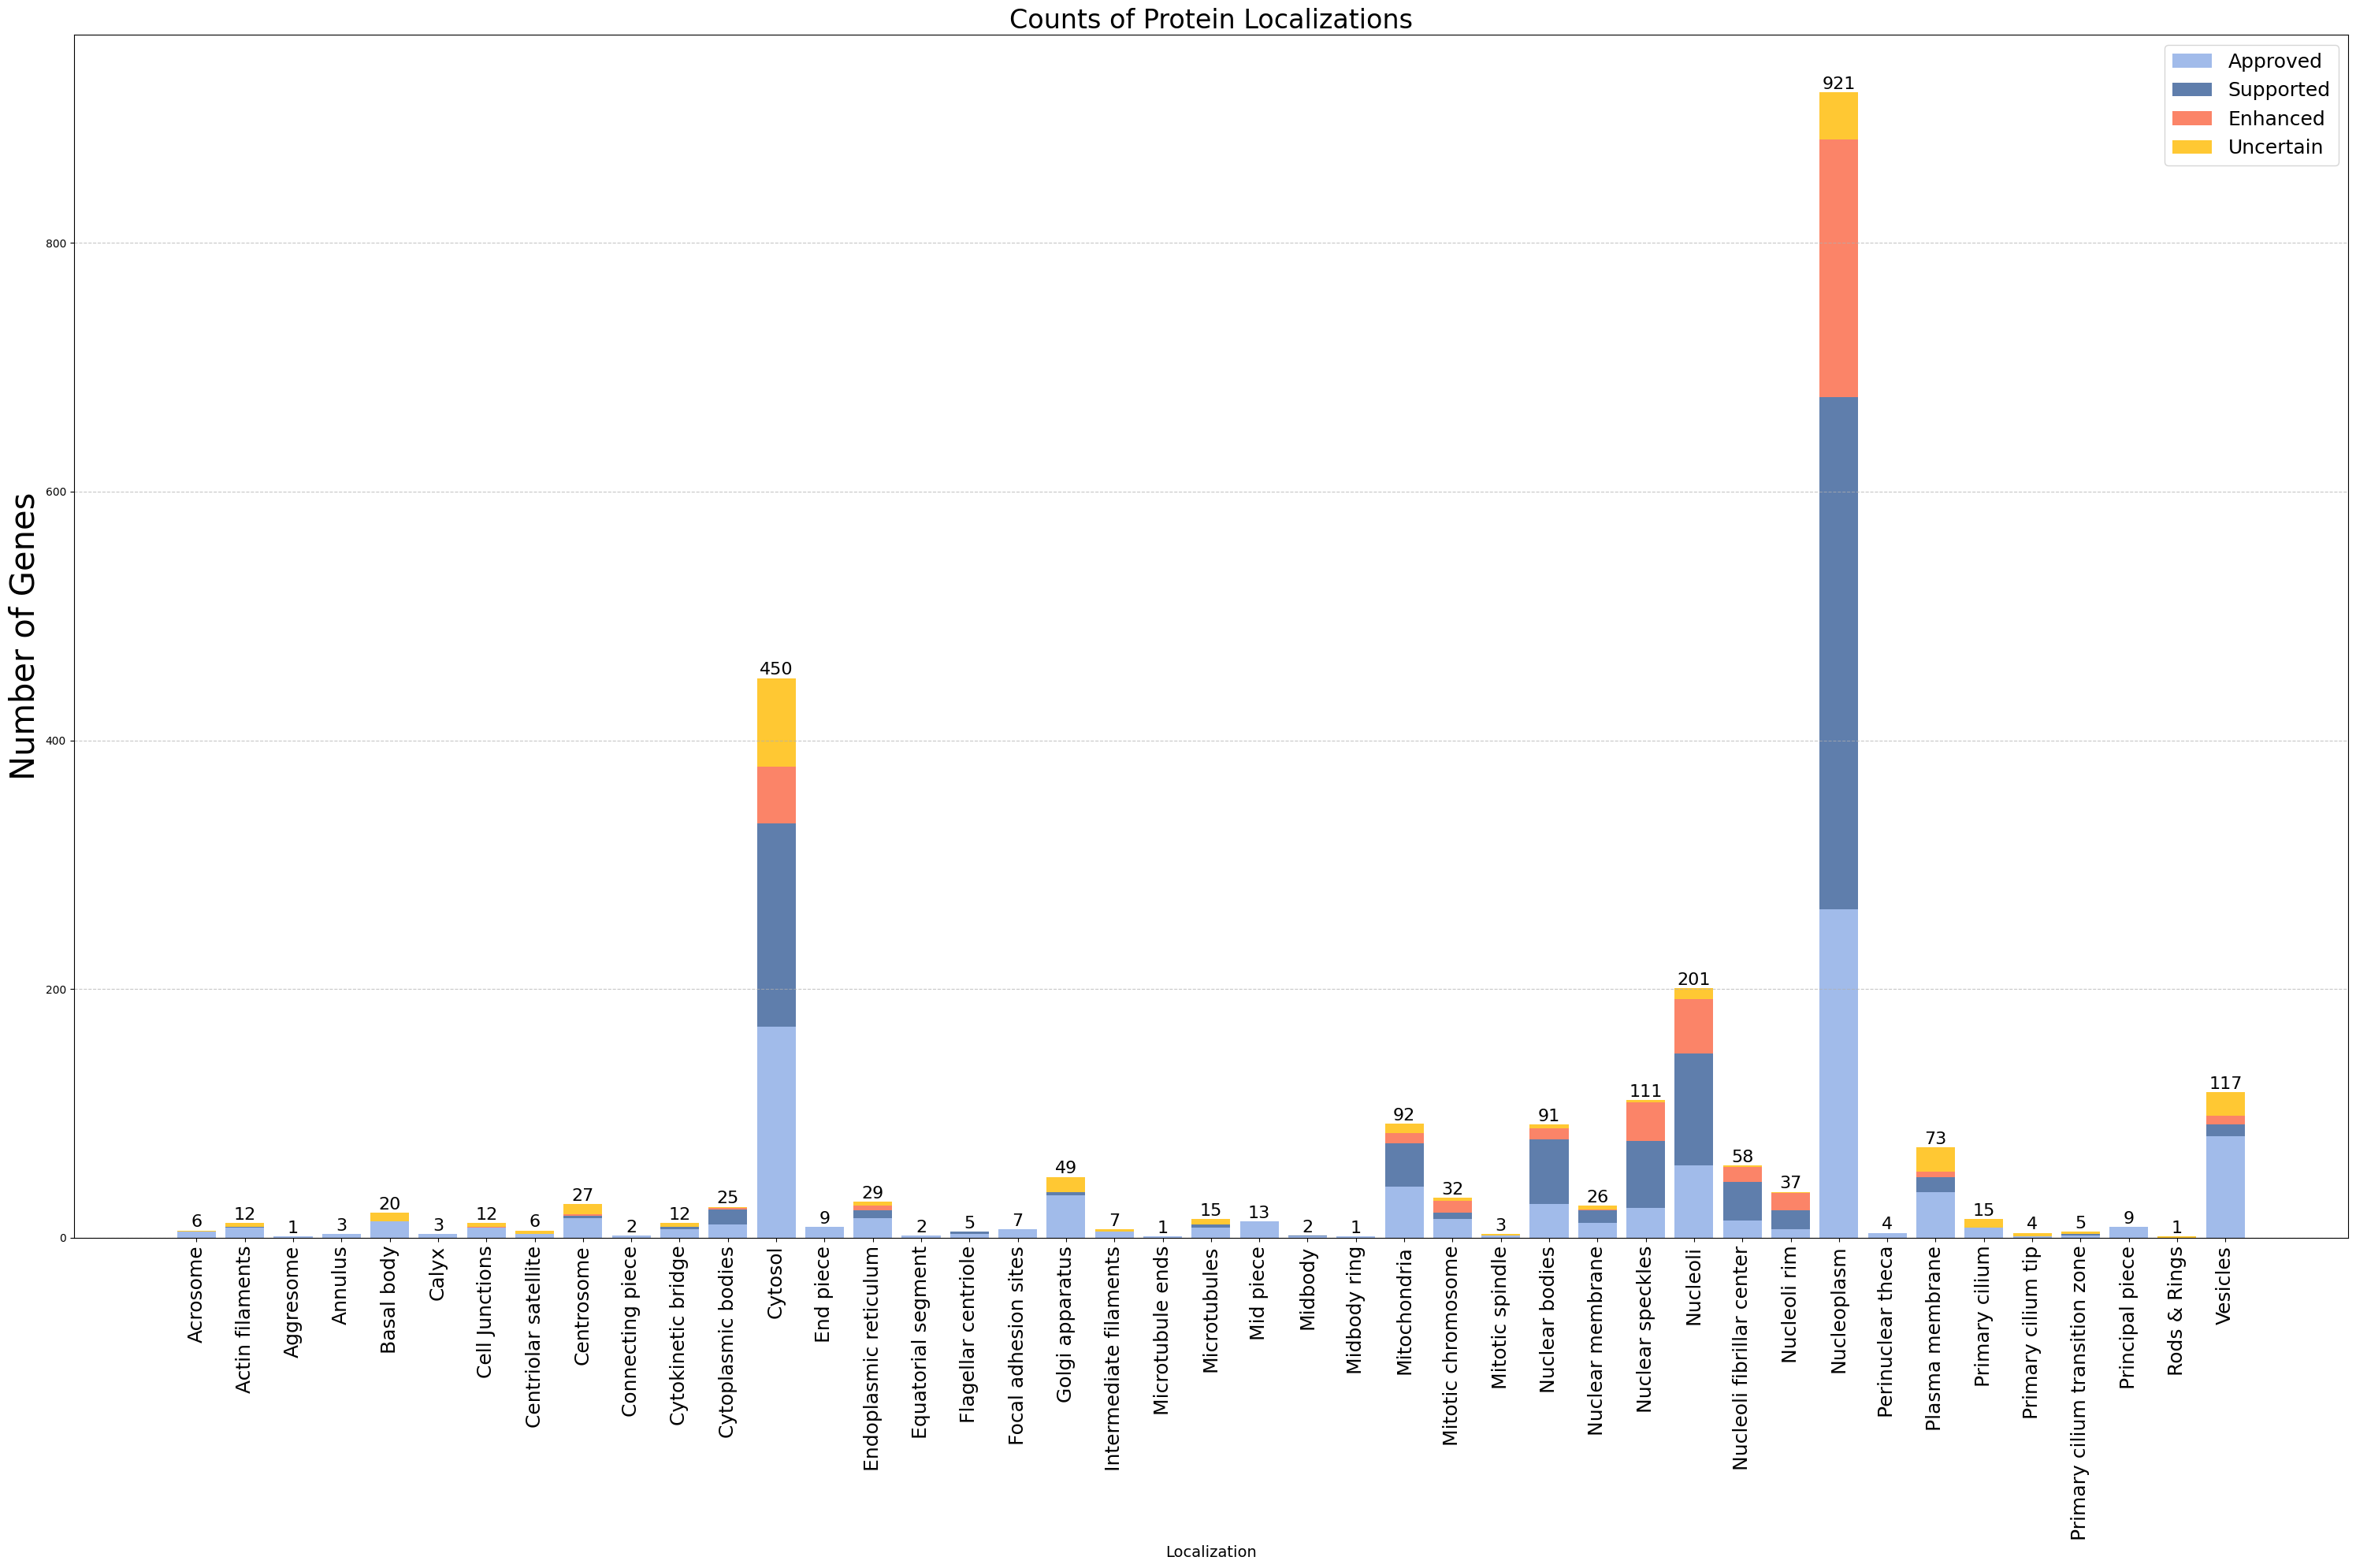

In [7]:
plot_location_of_genes(result_matrix=results, showReliability=True)

In [8]:
# select the localization of interest
results_cropped = results[["Gene name",
                           'Centrosome', 'Centriolar satellite', 'Aggresome', # Proteins localized close to centrosome
                           'Basal body','Primary cilium', 'Primary cilium tip', 'Primary cilium transition zone', # Proteins localized in the ciliagenesis process
                           'Flagellar centriole', 'Midbody', 'Midbody ring', 'Mitotic spindle']] # Proteins localized in the mitotic process

Number of locations with genes: 11
Number of locations excluded: 1
Excluded locations: {'Gene name'}


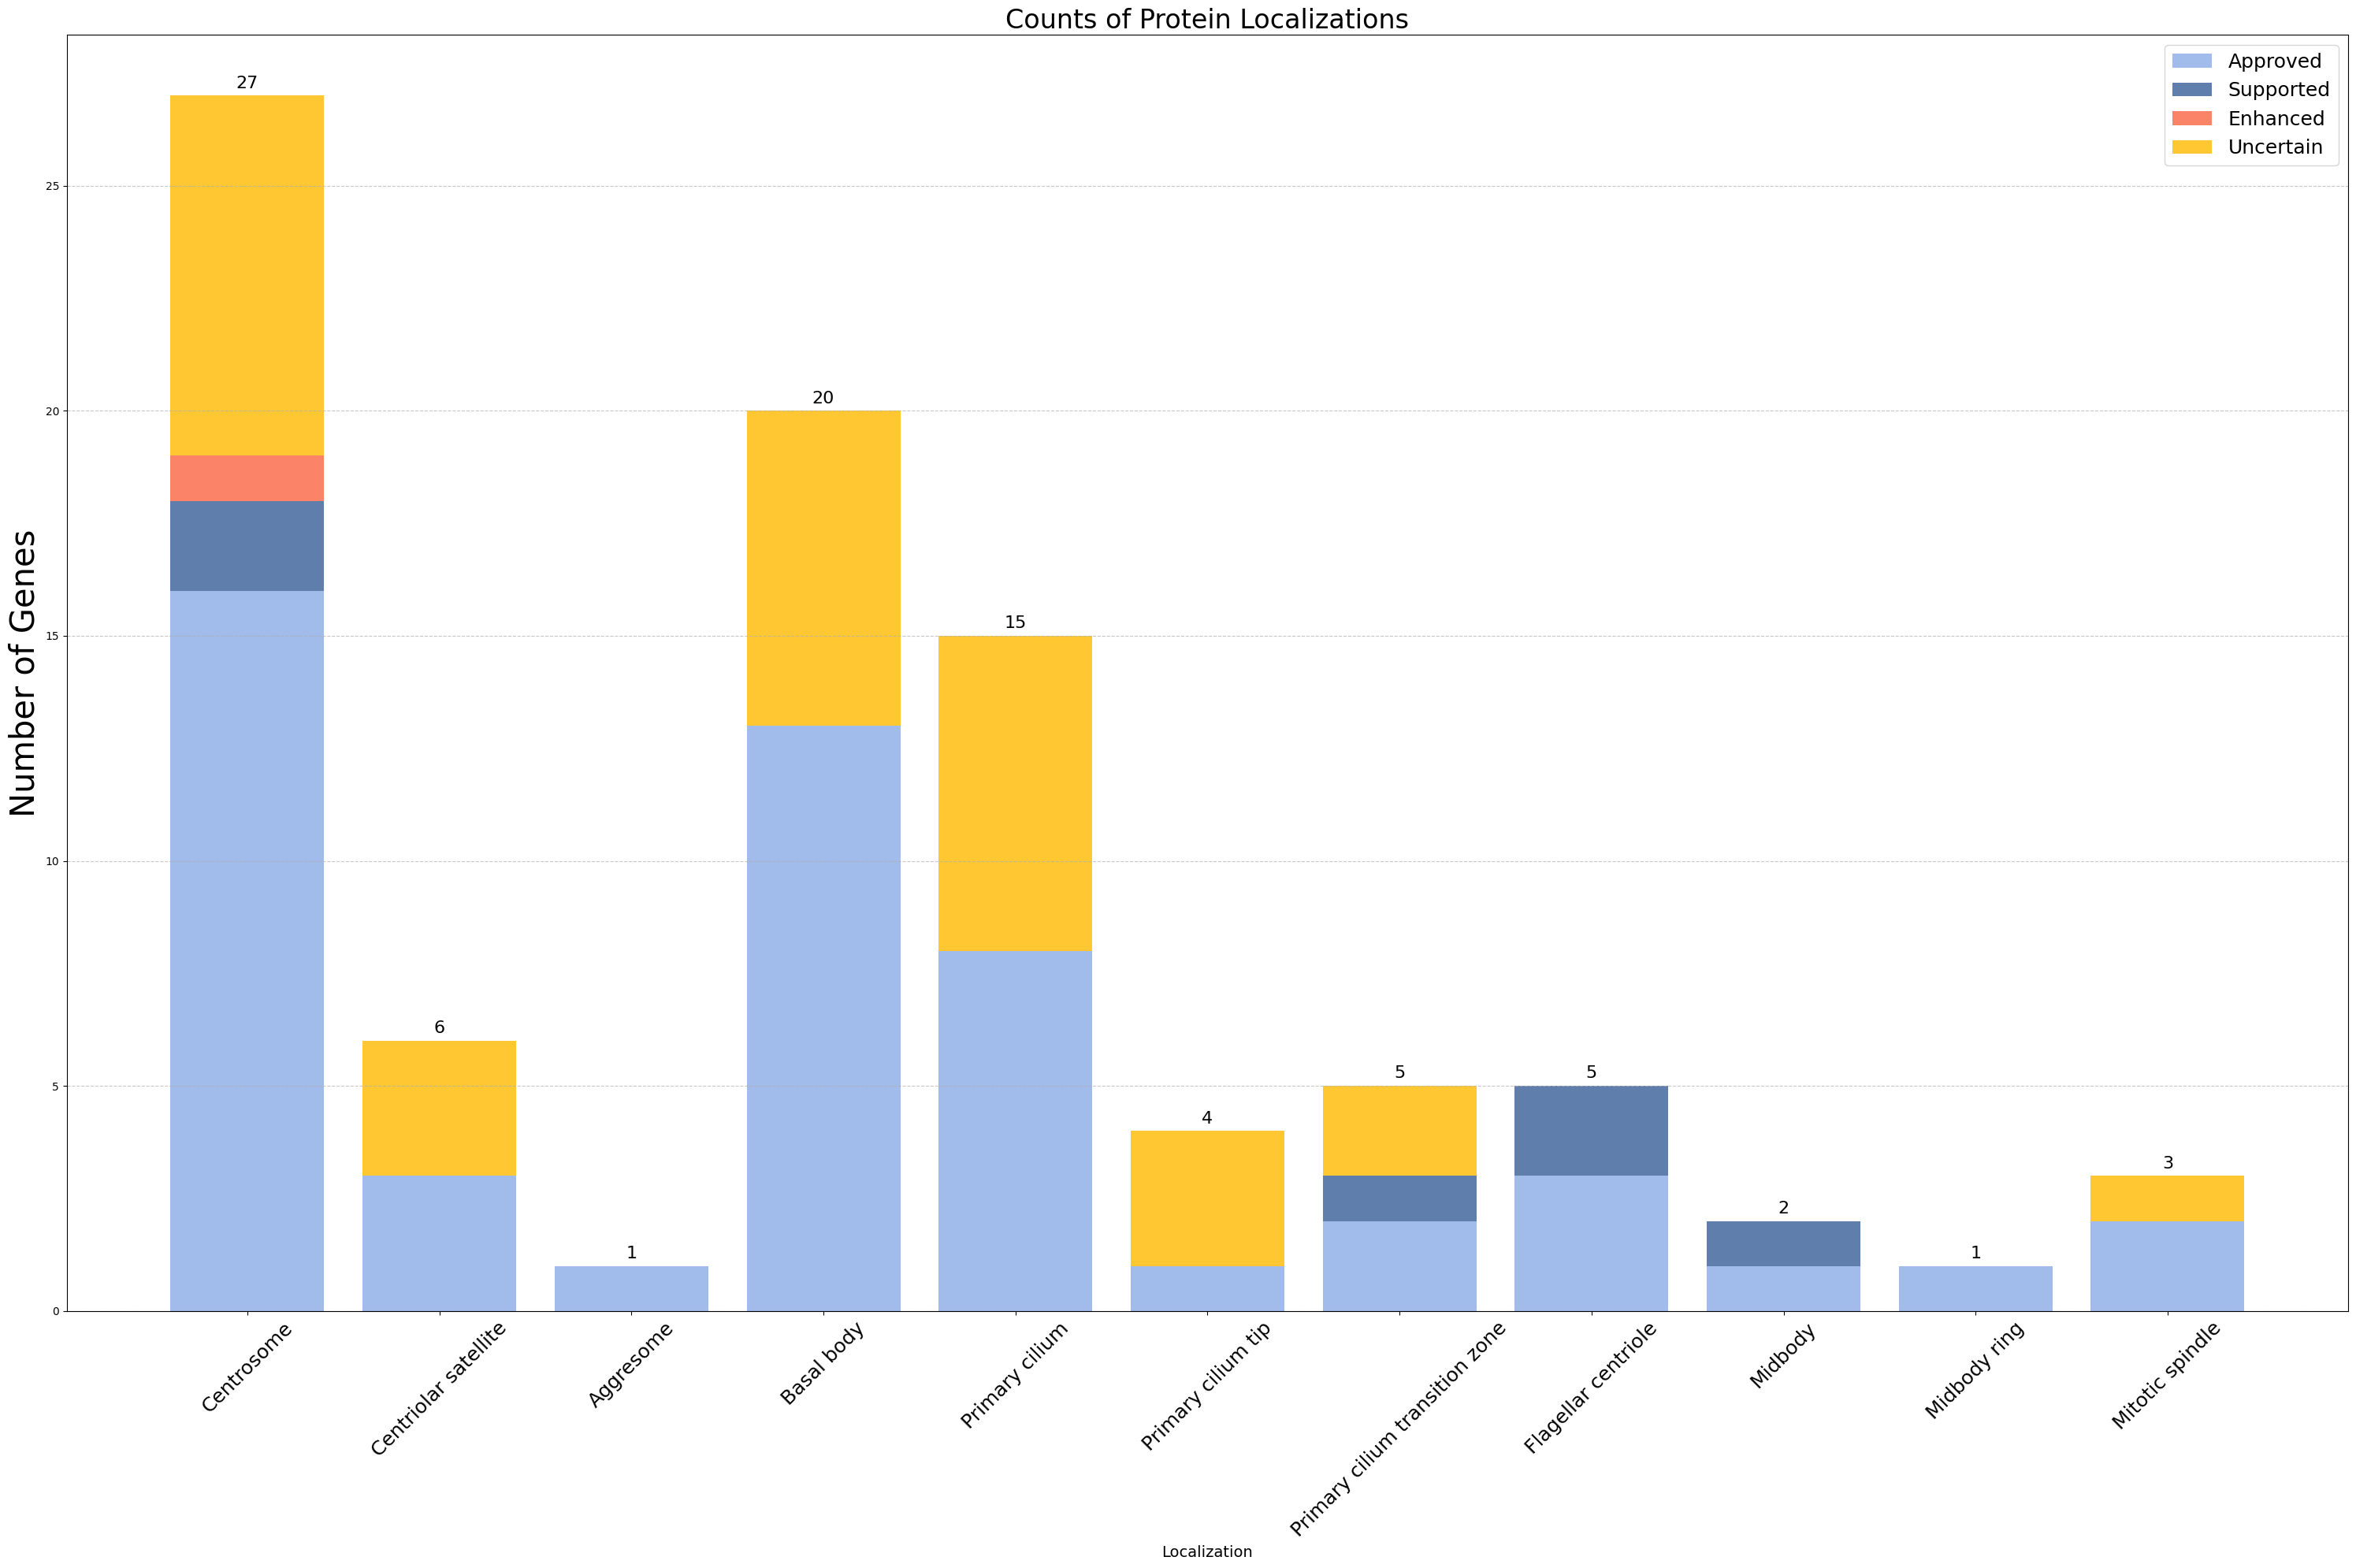

In [9]:
plot_location_of_genes(result_matrix=results_cropped, showReliability=True)

In [11]:
def find_proteins_localization(location, matrix, showReliability=False, save=False, outputpath=None):
    if location not in matrix.columns:
        print(f"Location '{location}' not found in the matrix.")
        return []
    if showReliability==False:
        localized_genes = matrix[matrix[location] >= 0]['Gene name'].tolist()
        if save:
            # Save the results to a file
            output_file = f"{outputpath}/{location}_localization_results.tsv"
            with open(output_file, 'w') as f:
                f.write("Gene name\n")
                for gene in localized_genes:
                    f.write(f"{gene}\n")
            return localized_genes
        else:
            return localized_genes
    if showReliability==True:
        # Get all genes with any localization value > 0
        localized_rows = matrix[matrix[location] >= 0]
        localized_genes = localized_rows['Gene name'].tolist()
        
        # Get reliability levels for each gene
        reliability_levels = []
        for _, row in localized_rows.iterrows():
            if row[location] == 1:
                reliability_levels.append('approved')
            elif row[location] == 2:
                reliability_levels.append('supported')
            elif row[location] == 3:
                reliability_levels.append('enhanced')
            elif row[location] == 0:
                reliability_levels.append('uncertain')
    if save:
        # Save the results to a file
        output_file = f"{outputpath}/{location}_allGenes_localization_results.tsv"
        with open(output_file, 'w') as f:
            f.write("Gene name\tReliability\n")
            for gene, reliability in zip(localized_genes, reliability_levels):
                f.write(f"{gene}\t{reliability}\n")
        return list(zip(localized_genes, reliability_levels))
    else:
        return list(zip(localized_genes, reliability_levels))

# find_proteins_localization("Centrosome", results, showReliability=False, save=True, outputpath='/home/jiguo/denovo_rpe1_scrnaseq/')

In [12]:
interested_locations = ['Centrosome', 'Centriolar satellite', 'Aggresome', # Proteins localized close to centrosome
                           'Basal body','Primary cilium', 'Primary cilium tip', 'Primary cilium transition zone', # Proteins localized in the ciliagenesis process
                           'Flagellar centriole', 'Midbody', 'Midbody ring', 'Mitotic spindle'] # Proteins localized in the mitotic process
for location in interested_locations:
    print(f"Finding proteins for location: {location}")
    print(find_proteins_localization(location, results, showReliability=False, save=True, outputpath='/home/jiguo/denovo_rpe1_scrnaseq/locations_of_genes/')   )

Finding proteins for location: Centrosome
['ATG5', 'AK6', 'POLR3H', 'APEX1', 'PRPF6', 'E2F1', 'DHX35', 'BUD31', 'OAS2', 'BCAS2', 'CREB1', 'CDK2', 'QRSL1', 'CTNNBL1', 'MFAP1', 'SMAD4', 'TSEN2', 'N6AMT1', 'ELP6', 'DCAF13', 'INTS6L', 'LEO1', 'DIS3L', 'TCEA2', 'MLF1', 'TDRKH', 'CNOT10']
Finding proteins for location: Centriolar satellite
['LAS1L', 'RIOK3', 'WDR83', 'RBM39', 'NUDT21', 'RPP25']
Finding proteins for location: Aggresome
['PRPF40B']
Finding proteins for location: Basal body
['POLA2', 'ATG5', 'SMG6', 'PRKACA', 'PRPF6', 'PQBP1', 'MAPK3', 'CREB3', 'USP4', 'NCBP2', 'CREB1', 'WDR83', 'SMAD4', 'DIS3L', 'SMAD3', 'CTNNB1', 'ADRB2', 'TCEA2', 'CSTF2T', 'MLF1']
Finding proteins for location: Primary cilium
['PRKACA', 'CLNS1A', 'GPATCH1', 'TRIP11', 'PQBP1', 'MAPK3', 'CREB3', 'GLIS3', 'RO60', 'RPAP2', 'BMP2', 'SNRNP200', 'GRHL3', 'CTNNB1', 'ADRB2']
Finding proteins for location: Primary cilium tip
['NR1H4', 'MAPK3', 'CREB3', 'SMAD4']
Finding proteins for location: Primary cilium transition 

In [ ]:
interested_locations = ['Centrosome', 'Basal body', 'Flagellar centriole', 'Aggresome', 
                           'Centriolar satellite', 'Midbody', 'Midbody ring', 'Mitotic spindle','']
for location in interested_locations:
    print(f"Finding proteins for location: {location}")
    print(find_proteins_localization(location, results, showReliability=False, save=True, outputpath='/home/jiguo/denovo_rpe1_scrnaseq/all_genes_in_this_location/'))

Finding proteins for location: Centrosome
['SPPL2B', 'PRKAR2B', 'PAFAH1B1', 'ST7L', 'PLEKHG6', 'MDH1', 'MTMR11', 'GLT8D1', 'STEEP1', 'RRAGD', 'LRRC7', 'CNTLN', 'MPHOSPH9', 'SDCCAG8', 'PLEKHH1', 'ATG5', 'CROCC', 'GNAI3', 'PKN2', 'KIF2A', 'DRD4', 'GNB5', 'VASH1', 'HMMR', 'CRMP1', 'ALPK1', 'GLI2', 'GTSE1', 'DYNC1I2', 'JADE1', 'TP73', 'RABL2B', 'NDC80', 'TRAF5', 'ERC1', 'PIBF1', 'TXLNA', 'AK6', 'TTC39A', 'AURKA', 'PXN', 'CDIP1', 'TBX15', 'CDC45', 'HDAC6', 'AAAS', 'PSMD5', 'SORBS1', 'CEP170B', 'SNAP29', 'LZTR1', 'CBY1', 'DNAL4', 'LMF2', 'NEFH', 'POLR3H', 'NIN', 'ISM2', 'CEP128', 'SLC8A3', 'PSMB5', 'APEX1', 'PRPF6', 'BIRC7', 'SIRPB1', 'POFUT1', 'MAPRE1', 'E2F1', 'DHX35', 'CEP192', 'SMAD7', 'FNDC3A', 'KATNAL1', 'ARL2BP', 'NUBP1', 'CEP152', 'CSPP1', 'ZFAND1', 'MTMR9', 'PIAS4', 'CLEC11A', 'RAB3A', 'PDE4C', 'GAPDHS', 'KXD1', 'CASP2', 'NPTX2', 'BUD31', 'NMRK1', 'AKNA', 'EDRF1', 'RAB34', 'SLAIN2', 'INPP4B', 'CPE', 'TRIM2', 'KMT5B', 'CEP164', 'CAPRIN2', 'CDKN1B', 'OAS2', 'NUP107', 'FANCE', 'FBXO9',